## imports

In [1]:
import tensorflow as tf
import os # accessing file systems
import matplotlib.pyplot as plt

import cv2
import numpy as np

In [3]:
class_list = os.listdir("data/")
print(class_list)

['bengal_cat', 'bombay_cat', 'himalayan_cat', 'persian_cat']


In [5]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
gpus

[]

## read dataset

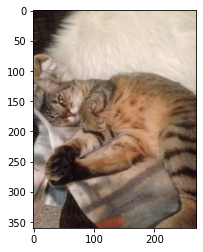

In [8]:
sample_img = cv2.imread(os.path.join("data/", "bengal_cat", "bengal_cat1098.jpg"))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)) # openCV reads as BGR and not RGB

In [33]:
data = tf.keras.utils.image_dataset_from_directory("data/",
                                                   batch_size=32,
                                                   # image_size=(512, 512),
                                                   class_names=class_list
                                                   )
# builds the dataset by labeling the images, resizing the images and even batching the images

Found 6892 files belonging to 4 classes.


In [34]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0].shape, batch[1].shape)

(32, 256, 256, 3) (32,)


In [35]:
batch[1]
# 0 - bengal
# 1 - bombay
# 2 - himalayan
# 3 - persian

array([3, 3, 3, 1, 2, 3, 0, 1, 1, 3, 1, 1, 1, 0, 0, 3, 0, 0, 1, 0, 1, 1,
       2, 0, 3, 0, 2, 1, 3, 1, 0, 1])

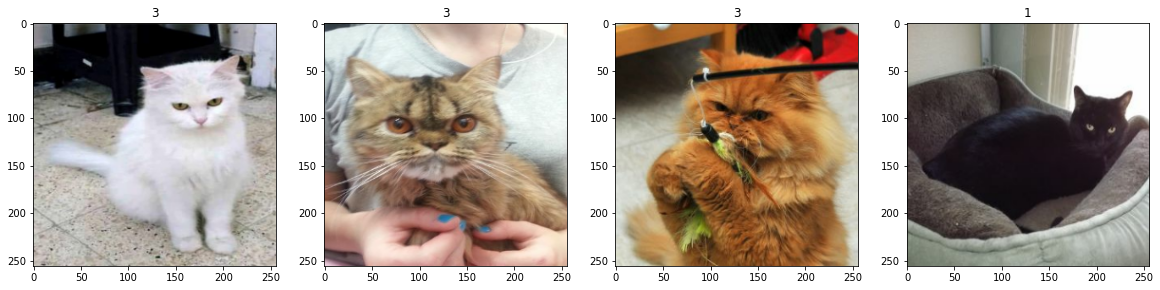

In [37]:
# let's figure the current batch out 😁
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]): # 1st 4 images of current batch
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## preprocess the data

In [38]:
# scale the data
data = data.map(lambda x, y: (x/255.0, y)) # x=pixel values and y=label

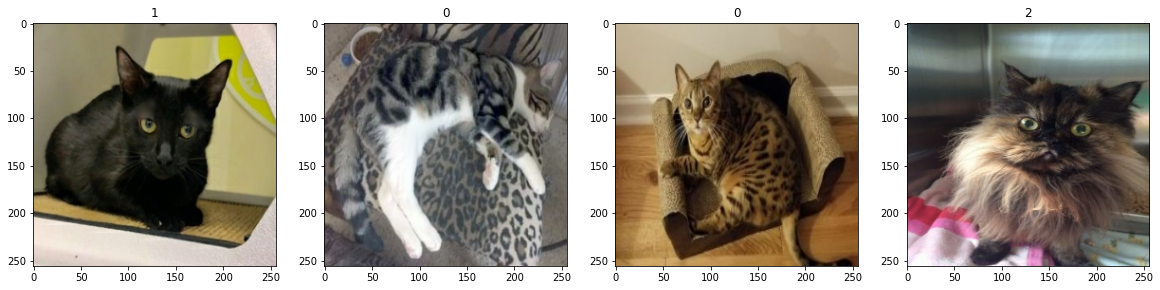

In [39]:
new_batch = data.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(new_batch[0][:4]): # 1st 4 images of current batch
    ax[idx].imshow(img)
    ax[idx].title.set_text(new_batch[1][idx])

plt.show()

# note that the pixel values values are now between 0. and 1.

## train-test-val split

In [40]:
len(data) # number of batches

216

In [41]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1
print(train_size+val_size+test_size) # = 216 is a must

216


In [42]:
# split the data
train = data.take(train_size) # tf method to take amount of data
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [43]:
len(train), len(val), len(test) # number of batches

(151, 43, 22)

## training the CNN model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [57]:
zf_net = tf.keras.Sequential()

zf_net.add(tf.keras.layers.Conv2D(filters=50, kernel_size=(11,11), strides=(4,4), input_shape=(256,256,3)))
zf_net.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2))

zf_net.add(tf.keras.layers.Conv2D(filters=100, kernel_size=(5,5), padding="same"))
zf_net.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2))

zf_net.add(tf.keras.layers.Conv2D(filters=150, kernel_size=(3,3), padding="same"))

# zf_net.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), padding="same"))

zf_net.add(tf.keras.layers.Conv2D(filters=120, kernel_size=(3,3), padding="same"))
zf_net.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2))

zf_net.add(tf.keras.layers.Flatten())

zf_net.add(Dense(2000, activation="relu"))
zf_net.add(Dropout(0.3))
zf_net.add(Dense(1000, activation="relu"))
zf_net.add(Dropout(0.2))
zf_net.add(Dense(4, activation="softmax"))

In [58]:
zf_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.Accuracy()
)

In [59]:
zf_net.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 50)        18200     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 50)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 30, 30, 100)       125100    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 100)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 150)       135150    
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 120)      

In [54]:
logdir = "logs"
# directory where all the model training stages (checkpoints) will be added

In [55]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [60]:
hist = zf_net.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5


ValueError: ignored

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()